# Logistic classifiers comparison

In [120]:
# Standard imports plus sci-kit learn classifiers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import scipy.stats

In [121]:
# data source: https://www.kaggle.com/uciml/adult-census-income#adult.csv
df = pd.read_csv('../../_Datasets/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [122]:
# We see an odd '?' value in the workclass feature
df.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [123]:
# Which features have this '?' value?
(df == '?').describe()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,1,2,1,1,1,1,2,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,32561,30725,32561,32561,32561,32561,30718,32561,32561,32561,32561,32561,32561,31978,32561


In [124]:
# Let's make a more clear Unknown value for '?'
df.workclass.replace('?', 'Unknown', inplace=True)
df.occupation.replace('?', 'Unknown', inplace=True)
df['native.country'].replace('?', 'Unknown', inplace=True)

In [125]:
# Inspect for the fix
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Unknown,77053,HS-grad,9,Widowed,Unknown,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Unknown,186061,Some-college,10,Widowed,Unknown,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [126]:
# Is there a significant class imbalance?
df.income.value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

### Notes: Hued pairplot

#### Some very fascinating trends can be immediately seen here.

Very often, we see that salaries exceeding $50,000 are surrounded by points with salaries that do not hit that mark, sometimes on every side! (Kernel tricks?)

F:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


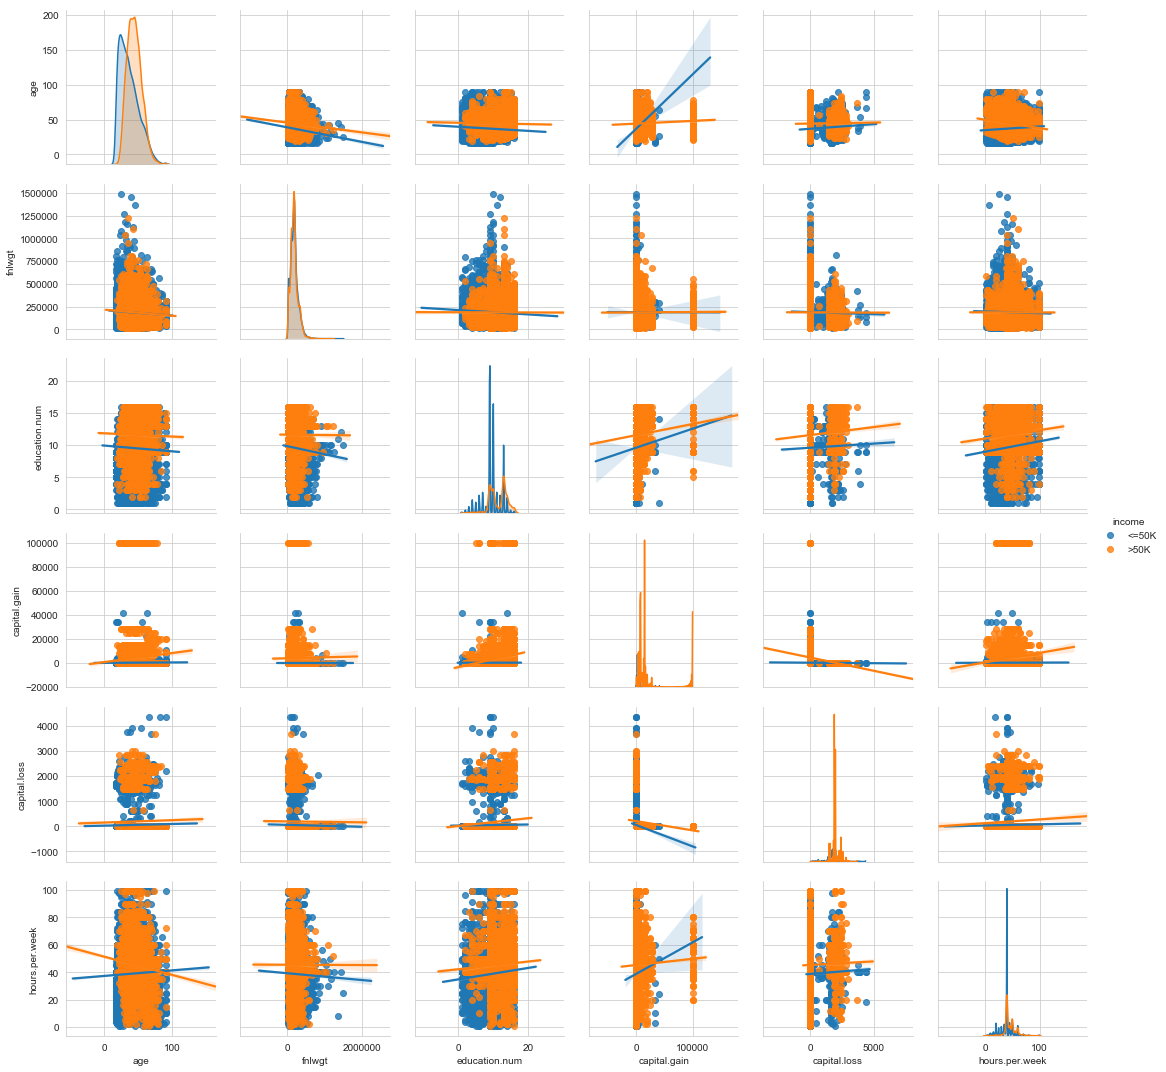

In [127]:
# Run a pairplot against the outcome to inspect obvious associations
sns.pairplot(df, hue='income', kind='reg')#, plot_kws={'truncate':True}) #plot_kws={'line_kws':{'color':['red', 'green']}, 'scatter_kws': {'alpha': 0.1}}

## Pairplot: Linearity and distributions

#### This pairplot gives us an idea about the linear relationships across features and their distributions.

Capital gain is not fitting against the other continuous features in a friendly way it all. Large confidence intervals make me think the feature creates overfitting. We can also see it exhibiting a very bimodal distribution. More on these later.

In [128]:
# Inspect for duplicates of different but similar names
for key in df.keys():
    if df[key].dtype == 'object':
        print(df[key].value_counts())

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
Unknown              1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         377

#### Notes: Categorical features

Most features do not contain too many options to incur the wrath of dimensionality. We will use a one-vs-all with the native.country feature - picking US against the others.

In [129]:
# Drop categorical features in favor of dummies
obj_keys = [key for key in df.keys() if df[key].dtype == 'object' and key != 'income' and key != 'native.country']
dummy_frame = [pd.get_dummies(df[key], prefix=key) for key in obj_keys]
df2 = pd.concat(dummy_frame, axis=1)
df2 = pd.concat([df2, df.select_dtypes(include='int64')], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df.income, prefix='HighIncome', drop_first=True)], axis=1)
df2 = pd.concat([df2, (df['native.country'] == 'United-States') * 1], axis=1)
df2['US_native'] = df2['native.country']
df2.drop(columns='native.country', inplace=True)
df2.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_10th,...,sex_Female,sex_Male,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,HighIncome_>50K,US_native
0,0,0,0,0,0,0,0,1,0,0,...,1,0,90,77053,9,0,4356,40,0,1
1,0,0,0,1,0,0,0,0,0,0,...,1,0,82,132870,9,0,4356,18,0,1
2,0,0,0,0,0,0,0,1,0,0,...,1,0,66,186061,10,0,4356,40,0,1
3,0,0,0,1,0,0,0,0,0,0,...,1,0,54,140359,4,0,3900,40,0,1
4,0,0,0,1,0,0,0,0,0,0,...,1,0,41,264663,10,0,3900,40,0,1


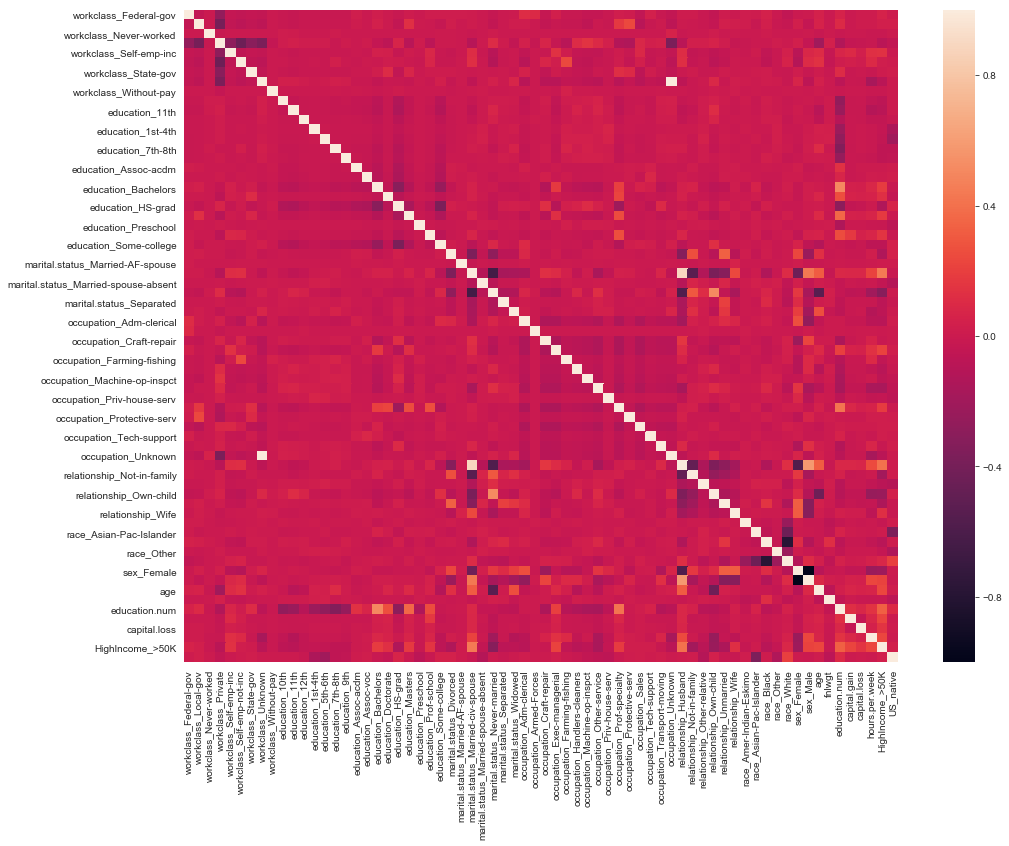

In [130]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df2.corr(), ax=ax)

#### Notes: Correlation on heatmap

It is a little worrisome that many purple and even darker spots are coming up on the heatmap. We are also observing some with strong positive correlations, seen as bright spots on the map.

## Model testing

#### Let's pull together some basic models and check out their performance across a ten-fold cross-validation.

In [131]:
X = df2.drop(columns='HighIncome_>50K')
y = df2['HighIncome_>50K']

las_clf = Lasso()
rid_clf = Ridge()
log_clf = LogisticRegression()

display(cross_val_score(las_clf, X, y, cv=10))
display(cross_val_score(rid_clf, X, y, cv=10))
display(cross_val_score(log_clf, X, y, cv=10))

array([-1.27373039,  0.00257147,  0.01646793,  0.01401507,  0.01654755,
        0.01830776,  0.01486009,  0.01864834,  0.01794918,  0.01833738])

array([-1.95415168,  0.2430981 ,  0.29397584,  0.29512906,  0.27292857,
        0.2980797 ,  0.31368908,  0.32551523,  0.31121664,  0.28846804])

array([0.45133558, 1.        , 0.92199017, 0.76474201, 0.75921376,
       0.75921376, 0.75921376, 0.75921376, 0.75921376, 0.75921376])

#### Notes: Performance metrics

I'm surprised the Lasso and Ridge don't perform better out of the box, as they had their own chapters as a type of logistic regression model/approach. Lasso is performing remarkably poorly, for some reason.

## Tweaking the models' parameters

#### We can try a grid search on the parameters to see if anything improves.

In [132]:
params = {'alpha': [1, 2, 3, 5, 10, 20, 100, 500], 'normalize': [True, False]}
las_grid = GridSearchCV(las_clf, params)
las_results = las_grid.fit(X, y)
display(las_results.best_params_)
display(las_results.best_score_)

rid_grid = GridSearchCV(rid_clf, params)
rid_results = rid_grid.fit(X, y)
display(rid_results.best_params_)
display(rid_results.best_score_)

# Throwing some different solvers into the grids for giggles
log_grid = GridSearchCV(log_clf, {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'max_iter': [100, 200, 400]})
log_results = log_grid.fit(X, y)
display(log_results.best_params_)
display(log_results.best_score_)

{'alpha': 1, 'normalize': False}

-0.018746359606506762

{'alpha': 5, 'normalize': False}

0.3081637873163554

F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anacond

{'max_iter': 200, 'solver': 'newton-cg'}

0.8278308405761494

#### Note: Grid search

No major benefits or surprises with the grid search. Let's keep trying.

## Addressing features issues: Capital gains

F:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


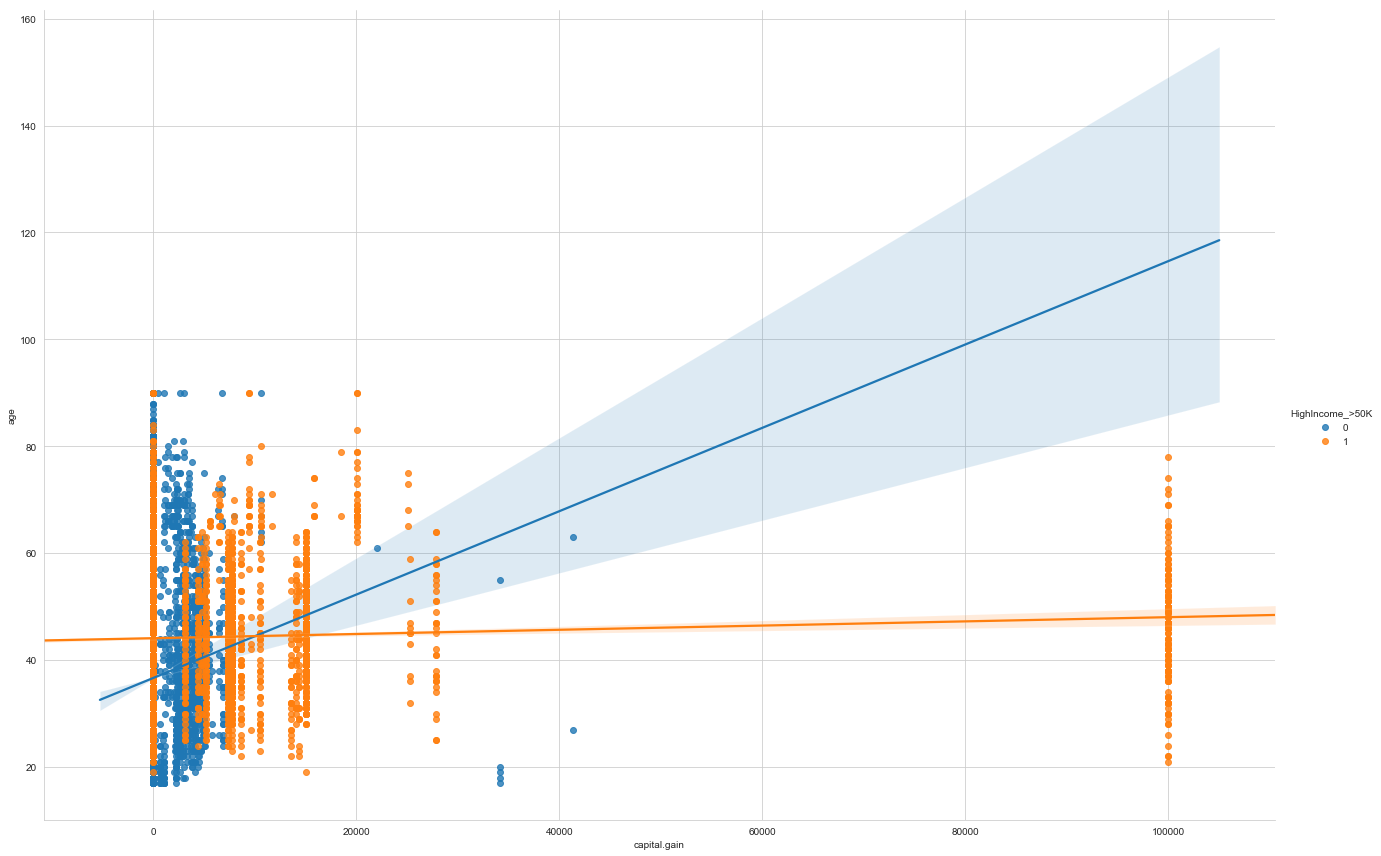

In [133]:
sns.lmplot('capital.gain', 'age', data=df2, hue='HighIncome_>50K', height=12, aspect=1.5)

F:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


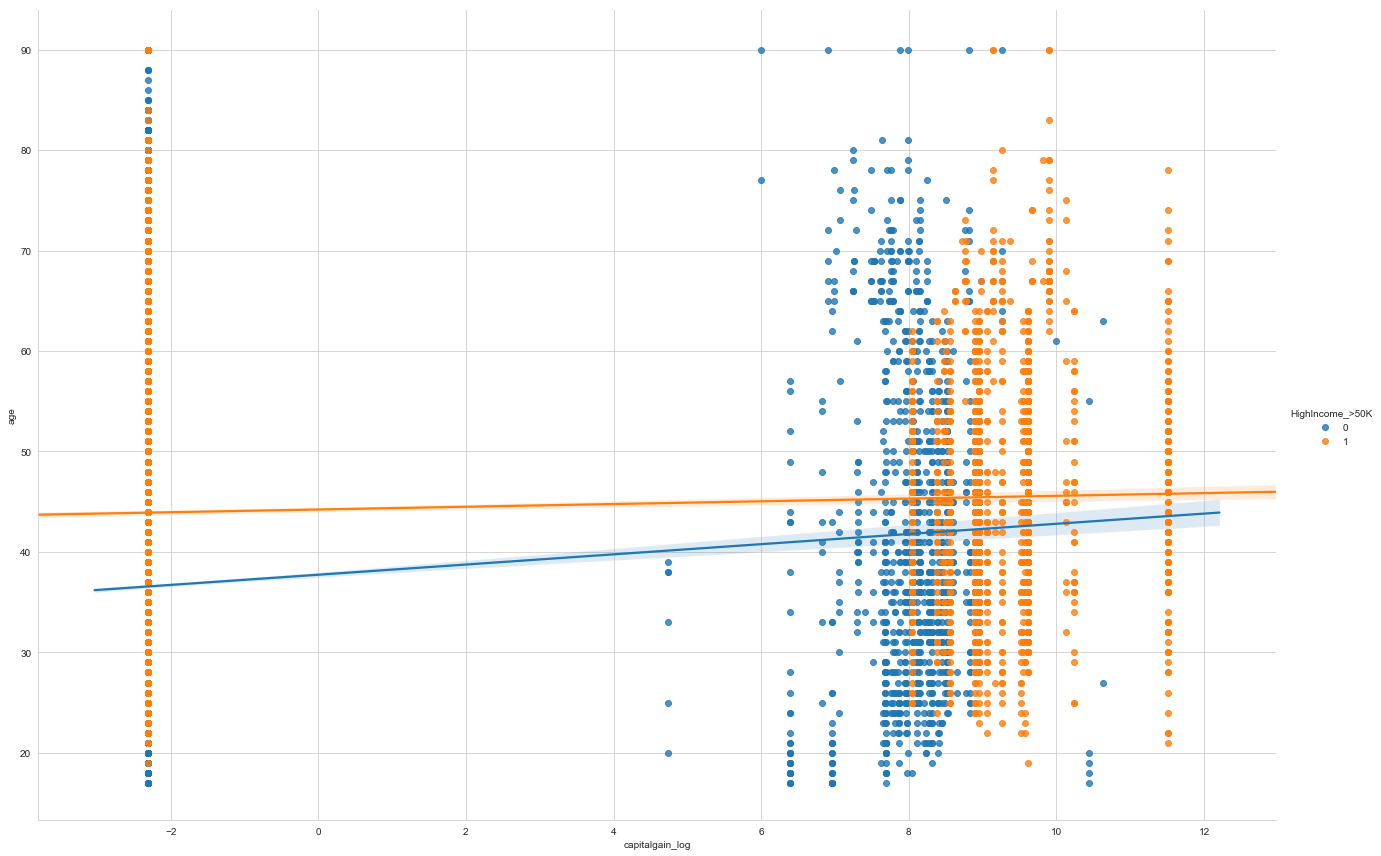

In [134]:
df2['capitalgain_log'] = np.log(df2['capital.gain'] + 0.1)
sns.lmplot('capitalgain_log', 'age', data=df2, hue='HighIncome_>50K', height=12, aspect=1.5)

#### Notes: Transformation

The former linear regression fit on these two features includes a massive confidence interval, indicating fitting is difficult.

The logarithmic transformation does a pretty good job at shrinking this interval and keeping the two regressions separate.

In [135]:
df2.drop(columns='capital.gain', inplace=True)

X = df2.drop(columns='HighIncome_>50K')
y = df2['HighIncome_>50K']

las_clf = Lasso()
rid_clf = Ridge()
log_clf = LogisticRegression()

display(cross_val_score(las_clf, X, y, cv=10))
display(cross_val_score(rid_clf, X, y, cv=10))
display(cross_val_score(log_clf, X, y, cv=10))

array([-1.27373039,  0.01290431,  0.02188331,  0.0184326 ,  0.02223212,
        0.02670595,  0.02054902,  0.02721839,  0.026157  ,  0.02688774])

array([-0.41038946, -0.16881157,  0.29702142,  0.29989569,  0.27697211,
        0.30094489,  0.31607967,  0.32618092,  0.31326922,  0.2922104 ])

array([0.75898066, 0.75921376, 0.75921376, 0.75921376, 0.75921376,
       0.75921376, 0.75921376, 0.75921376, 0.75921376, 0.75921376])

#### Notes: Effects of logarithmic transformation

The standard logistic regression model seems to significantly benefit from this transformation: it has become very consistent and maybe no longer overfits.

## Addressing features issues: Multicollinearity problems

### We can take a closer look at the values processed by the heatmap to see what numbers turn up.

In [136]:
# Disregard perfect 1 correlations as these are correlations with the self
df2.corr()[df2.corr() != 1].describe()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_10th,...,sex_Female,sex_Male,age,fnlwgt,education.num,capital.loss,hours.per.week,HighIncome_>50K,US_native,capitalgain_log
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,-0.003321,-0.005516,-0.001106,-0.040759,-0.002464,-0.008081,-0.006174,-0.009320,-0.000929,-0.013913,...,-0.016910,-0.012941,0.012602,-0.003171,-0.001431,0.003397,0.003840,0.013842,-0.011057,0.007842
std,0.045922,0.070556,0.010482,0.122947,0.062747,0.079194,0.052507,0.140052,0.009232,0.045214,...,0.184837,0.185162,0.125150,0.029180,0.161333,0.036393,0.097592,0.143955,0.070690,0.060620
min,-0.264369,-0.397547,-0.022242,-0.441289,-0.285747,-0.441289,-0.309064,-0.370780,-0.031458,-0.272428,...,-1.000000,-1.000000,-0.534359,-0.076646,-0.336268,-0.065012,-0.249254,-0.318440,-0.365437,-0.106647
25%,-0.022340,-0.024965,-0.004660,-0.068539,-0.031029,-0.035638,-0.020369,-0.053373,-0.004430,-0.024410,...,-0.041148,-0.039487,-0.017809,-0.016551,-0.091261,-0.016267,-0.039324,-0.072212,-0.020203,-0.023731
50%,-0.002473,-0.006968,-0.002602,-0.004264,-0.010316,-0.005614,-0.004226,-0.011179,-0.002108,-0.012982,...,-0.000989,-0.000436,0.015624,-0.002598,-0.008136,-0.004806,-0.003096,-0.012576,0.005669,-0.005936
75%,0.015122,0.014916,-0.000788,0.027903,0.012509,0.016812,0.012772,0.008685,0.001655,0.011385,...,0.038329,0.033616,0.055972,0.008952,0.076295,0.015903,0.058687,0.072298,0.016803,0.018745
max,0.116805,0.234997,0.059866,0.143986,0.139467,0.234560,0.117317,0.997985,0.047987,0.060787,...,0.321273,0.580135,0.316875,0.118009,0.503435,0.150526,0.246164,0.444696,0.200004,0.285003


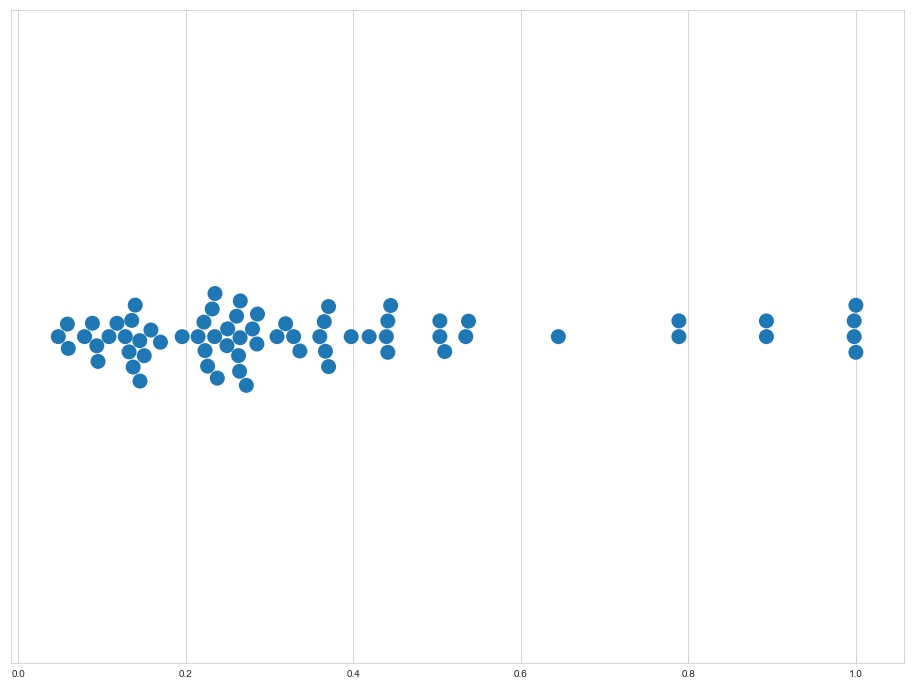

In [137]:
plt.figure(figsize=(16,12))
sns.swarmplot(np.abs(df2.corr())[df2.corr() != 1].max(), size=15)

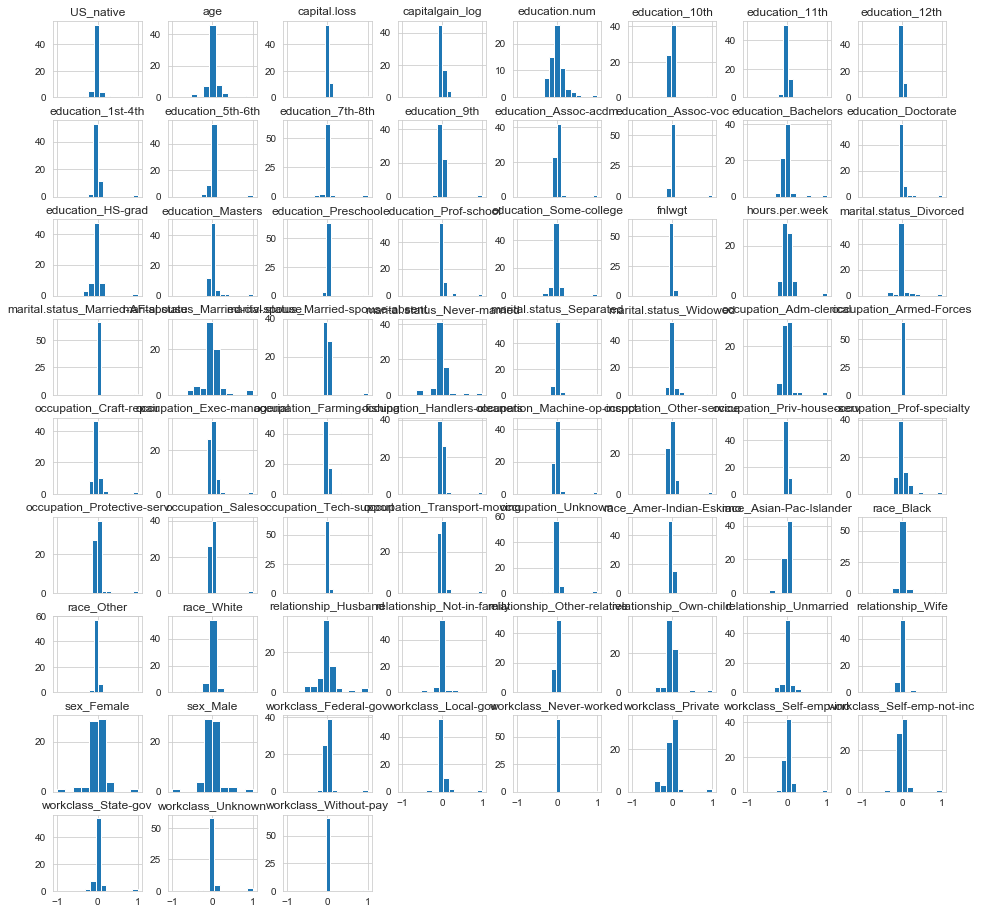

In [138]:
df2.drop(columns='HighIncome_>50K').corr().hist(figsize=(16,16), sharex=True)
plt.show()

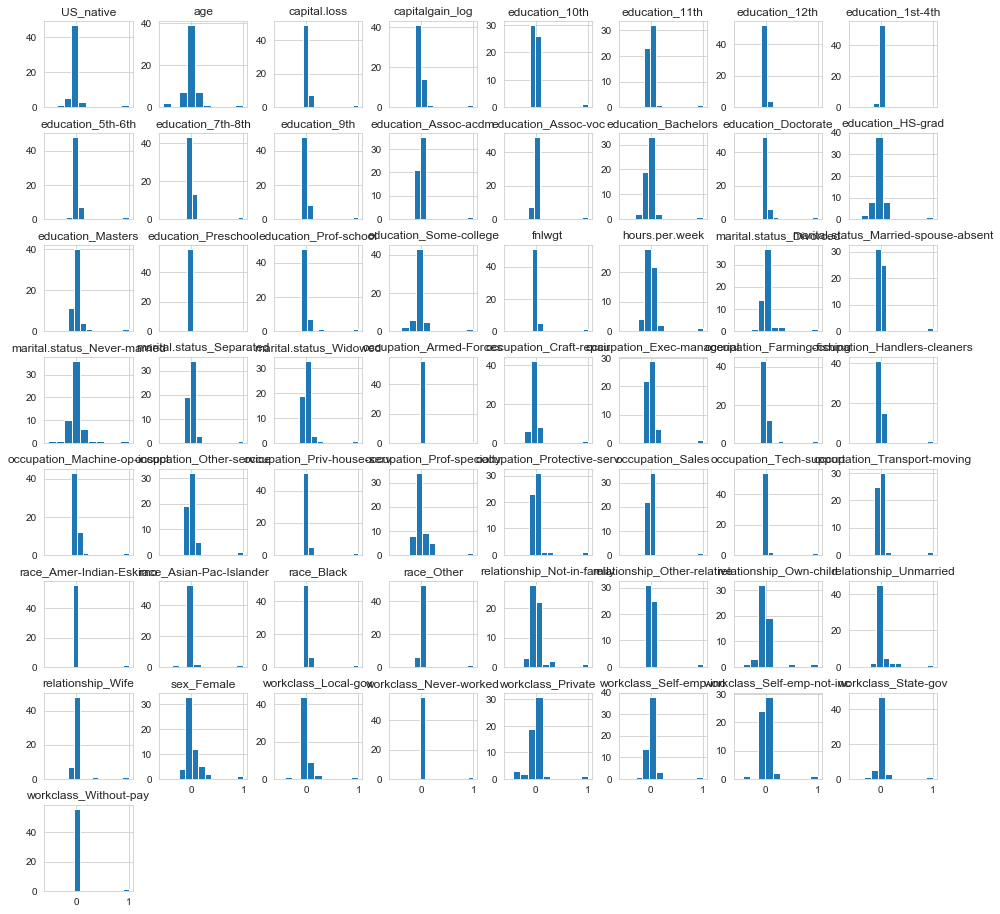

In [139]:
df2.drop(columns=['HighIncome_>50K', 'sex_Male', 'relationship_Husband', 'workclass_Federal-gov',
                 'occupation_Adm-clerical', 'marital.status_Married-AF-spouse', 'education.num', 
                 'marital.status_Married-civ-spouse', 'workclass_Unknown', 
                  'occupation_Unknown', 'race_White']).corr().hist(figsize=(16,16), sharex=True)
plt.show()

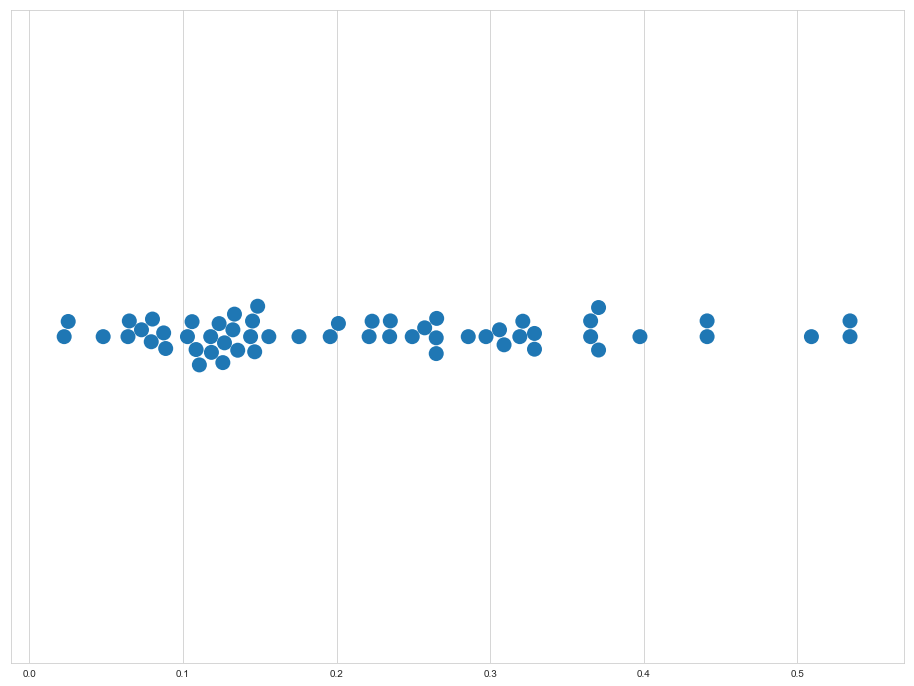

In [140]:
df2.drop(columns=['sex_Male', 'relationship_Husband', 'workclass_Federal-gov',
                 'occupation_Adm-clerical', 'marital.status_Married-AF-spouse', 'education.num', 
                 'marital.status_Married-civ-spouse', 'workclass_Unknown',
                  'occupation_Unknown', 'race_White'], inplace=True)
plt.figure(figsize=(16,12))
sns.swarmplot(np.abs(df2.drop(columns='HighIncome_>50K').corr())[df2.corr() != 1].max(), size=15)

In [141]:
X = df2.drop(columns='HighIncome_>50K')
y = df2['HighIncome_>50K']

las_clf = Lasso()
rid_clf = Ridge()
log_clf = LogisticRegression()

display(cross_val_score(las_clf, X, y, cv=10))
display(cross_val_score(rid_clf, X, y, cv=10))
display(cross_val_score(log_clf, X, y, cv=10))

array([-1.27373039,  0.01290431,  0.02188331,  0.0184326 ,  0.02223212,
        0.02670595,  0.02054902,  0.02721839,  0.026157  ,  0.02688774])

array([-0.41145437, -0.17128317,  0.29766978,  0.29884292,  0.27332891,
        0.30045954,  0.31333739,  0.32490176,  0.31244047,  0.28964505])

array([0.75898066, 0.75921376, 0.75921376, 0.75921376, 0.75921376,
       0.75921376, 0.75921376, 0.75921376, 0.75921376, 0.75921376])

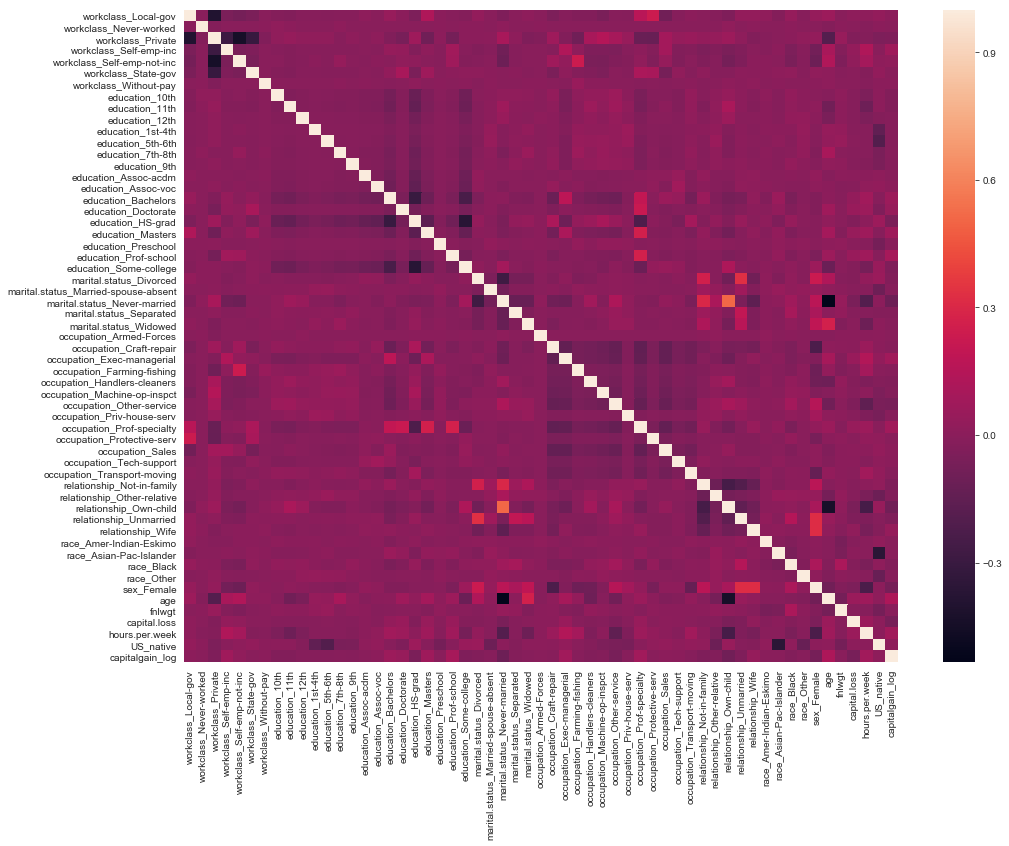

In [142]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(X.corr())

#### Notes: Reduced multicollinearity

This does not seem to have much of an effect - the results are nearly identical to the previous test. The heatmap does indicate the collinearity issues are much cleaner.

## Final GridSearchCV

#### We can try a final addition of max_iter parameters

In [143]:
params = {'alpha': [1, 2, 3, 5, 10, 20, 100, 500], 'normalize': [True, False]}
las_grid = GridSearchCV(las_clf, params)
las_results = las_grid.fit(X, y)
display(las_results.best_params_)
display(las_results.best_score_)

rid_grid = GridSearchCV(rid_clf, params)
rid_results = rid_grid.fit(X, y)
display(rid_results.best_params_)
display(rid_results.best_score_)

# Throwing some different solvers into the grids for giggles
log_grid = GridSearchCV(log_clf, {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'max_iter': [100, 200, 400]})
log_results = log_grid.fit(X, y)
display(log_results.best_params_)
display(log_results.best_score_)

{'alpha': 1, 'normalize': False}

-0.01531293052154801

{'alpha': 1, 'normalize': False}

0.3105230769085611

F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
F:\Anacond

{'max_iter': 200, 'solver': 'newton-cg'}

0.8344645434722521

## Conclusions

#### It appears that the pretty standard logistic regression model performs much better than the others. 

Even with extensive tweaking, this model barely performs better than the first with a GridSearchCV.

With a few more projects, I might be able to understand when the penalties fit the data set.